# Handwritten Equation Solver
In this project we came up with multiple methods to solve handwritten equations and provide a live demo of the process.

### Project Repo 
https://github.com/staubertTim/equation_solver

### Course and Semester
Deep Learning WS 2022/2023

### Participants
- Jeremy von Winckelmann
- Fynn Junge
- Tim Staubert

### Outline
We decided to build a pipeline of individual blocks that solve a specific task and putting it together in the end.
First we will show two approaches of splitting the input image and recognizing the resulting (hopefully) single digits/symbols.

In the end we present an all-in-one approach using a transformer model for text recognition.

## Building Block 1: Input From HTML Canvas

**Input:** Graphical input supplied by the user

**Output:** A representation of said input as a np.array

---

This block is responsible for prompting the user to draw an image and store it as a Python variable.  
In the following we define a simple HTML interface and use the IPython.display library to render it to the user. The canvas can be reset with the left button at any time and upon submission via the green button the resulting image will be returned by the function `draw_canvas`.

In [1]:
from IPython.display import HTML
from google.colab.output import eval_js
from base64 import b64decode
from PIL import Image
import io
import numpy as np

canvas_html = """
<style>
canvas {
  border-style: dashed;
}
button {
  border-radius: 0.5em; background: #fff; 
  padding: 0.2em 0.5em;  transition: background-color 0.2s;
  margin: 0.5em; cursor: pointer;
}
button.send {
  border: 2px solid green; color: green;
}
button.send:hover {
  background-color: lightgreen;
}
button.reset {
  border: 2px solid red; color: red;
}
button.reset:hover {
  background-color: #fcc;
}
</style>
<canvas width=%d height=%d></canvas>
<br />
<button class='reset' onclick='ctx.clearRect(0,0,canvas.width,canvas.height)'>
  Reset Canvas
</button>
<button class='send'>Submit Drawing</button>
<script>
var canvas = document.querySelector('canvas')
var ctx = canvas.getContext('2d')
ctx.lineWidth = %d
var button = document.querySelector('button.send')
var mouse = {x: 0, y: 0}
canvas.addEventListener('mousemove', function(e) {
  mouse.x = e.pageX - this.offsetLeft
  mouse.y = e.pageY - this.offsetTop
})
canvas.onmousedown = ()=>{
  ctx.beginPath()
  ctx.moveTo(mouse.x, mouse.y)
  canvas.addEventListener('mousemove', onPaint)
}
canvas.onmouseup = ()=>{
  canvas.removeEventListener('mousemove', onPaint)
}
var onPaint = ()=>{
  ctx.lineTo(mouse.x, mouse.y)
  ctx.stroke()
}
var data = new Promise(resolve=>{
  button.onclick = ()=>{
    resolve(canvas.toDataURL('image/png'))
  }
})
</script>
"""

def draw_canvas(w=1024, h=128, line_width=3) -> np.array:
  """
  This function displays a HTML canvas in the notebook and returns the drawing
  as a numpy array, when the green button is clicked.

  Args: None

  Returns: 
  """

  display(HTML(canvas_html % (w, h, line_width)))
  data = eval_js("data")
  binary = b64decode(data.split(',')[1])
  img = Image.open(io.BytesIO(binary))
  return np.asarray(img)[:,:,3]

**Execute the cell below, draw on the canvas and then click the green button below it**  
The drawing will be handled in JavaScript and once finished, the image data will be uploaded in the Python variable `input_img` of type np.array.


In [10]:
input_img = draw_canvas()

**To see whether it worked, the cell below will display the image with matplotlib**

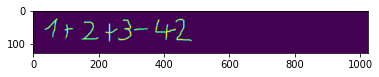

In [11]:
import matplotlib.pyplot as plt

plt.imshow(input_img)

## Building Block 2: Object Detection And Image Cropping

**Input:** A single image containing the expression to calculate

**Output:** A list of sub-images, containing one digit/symbol each

---

In [4]:
import cv2
import matplotlib.pyplot as plt
import numpy as np

In [5]:
def split_by_white_line(image: np.array) -> list:

    """
    This function takes an image of a formula and is able to' recognize individual charcters in the image by detecting a vertical, straight white line between them. 
	  When characters touch, they will unfortunately be recognized as one.
	  The characters are then cut out from the image and returned in the right order.

    Args: 
	    image (np.array): A two-dimensional np.array of the image that is to be processed.

	  Returns:
		  numbers (list[np.array]): A list of all the recognized digits (or combination of digits) as numpy arrays
    """

    threshold_image = np.where(image > 25, 1, 0)

    detected_character_start = False
    character_y_boundaries = []
    single_character_y_boundaries = [0, 0]

    for i in range(0, image.shape[1]):
        stripe = threshold_image[:,i]
        if np.sum(stripe) > 2 and not detected_character_start:
            detected_character_start = True
            single_character_y_boundaries[0] = i
        if np.sum(stripe) < 2 and detected_character_start:
            detected_character_start = False
            single_character_y_boundaries[1] = i
            character_y_boundaries.append(single_character_y_boundaries.copy())

    characters = []
    for i in character_y_boundaries:
        characters.append(image[:,i[0]:i[1]])

    detected_character_start = False
    character_x_boundaries = []
    single_character_x_boundaries = [0, 0]

    for index, character in enumerate(characters):
        for i in range(0, character.shape[0]):
            stripe = character[i,:]
            stripe = np.where(stripe > 25, 1, 0)
            if np.sum(stripe) > 2 and not detected_character_start:
                detected_character_start = True
                single_character_x_boundaries[0] = i
            if np.sum(stripe) < 2 and detected_character_start:
                detected_character_start = False
                single_character_x_boundaries[1] = i
                characters[index] = characters[index][single_character_x_boundaries[0]:single_character_x_boundaries[1], :]

    return characters

In [6]:
def split_by_contour(image: np.array) -> list:

	"""
	This function takes an image of a formula and is able to recognize individual characters in the image by detecting any white spae between them. 
	When characters touch, they will unfortunately be recognized as one.
	The characters are then cut out from the image and returned in the right order.

	Args: 
	    image (np.array): A two-dimensional np.array of the image that is to be processed.

	Returns:
		numbers (list[np.array]): A list of all the recognized digits (or combination of digits) as numpy arrays
	"""

	_, thresh = cv2.threshold(image, 0, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU) # Apply a threshold to make the image binary

	## FIND THE CONTOURS OF THE IMAGE ## 
	contours, hierarchy = cv2.findContours(thresh, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE) # Select the contours and their hierarchy
	
	## DISCARD INNER CONTOURS ##
	filtered_contours = []
	for i, contour in enumerate(contours):
		if hierarchy[0,i,3] == -1: # If this is not -1, the contour lies within another contour per definition
			filtered_contours.append(contour)

	## SORT CONTOURS FROM LEFT TO RIGHT ##
	i = 0
	boundingBoxes = [cv2.boundingRect(c) for c in filtered_contours]
	(filtered_contours, _) = zip(*sorted(zip(filtered_contours, boundingBoxes), key=lambda b:b[1][i], reverse=False)) # Sort the characters according to their appearance in the formula
	
	numbers = []

	## CUT OUT THE NUMBERS FROM THE IMAGE ##
	for index, c in enumerate(filtered_contours):
		rect = cv2.boundingRect(c)
		x,y,w,h = rect
		numbers.append(image[y:y+h,x:x+w])

	return numbers

In [7]:
import math

def rescale_img(img:np.array, dims=(28,28)) -> np.array:
  """
  Rescales img to dims, maintaining aspect ratio by padding
  
  Args:
    img: (np.array)
    dims: (tuple) image output size

  Returns:
    img: (np.array) a padded and rescaled representation of input image
  """
  h, w = img.shape
  t = b = l = r = 2
  if (w > h):
    t += math.floor((w-h)/2)
    b += math.ceil((w-h)/2)
  if (h > w):
    l += math.floor((h-w)/2)
    r += math.ceil((h-w)/2)

  img = cv2.copyMakeBorder(img, t, b, l, r, cv2.BORDER_CONSTANT, value=[0])
  img = cv2.resize(img, dsize=dims)

  return img

In [8]:
import math

def plot_image_list(images, labels=[], figure_title="", ncols=3):
    """
    Helper function to plot image list in a grid with optional labels.

    Args:
      images: (list) list of images in np.array format
      (optional) labels: (list) list of labels to display with the images
      (optional) figure_title: (string)

    Returns:
      None
    """
    nrows = math.ceil(len(images) / ncols)
    IMSIZE = 8

    fig = plt.figure(figsize=(IMSIZE, IMSIZE))
    fig.suptitle(figure_title)

    for i in range(len(images)):
        img = images[i]
        img = rescale_img(img)
        title = ""

        if (i < len(labels)):
          title = labels[i]

        fig.add_subplot(nrows, ncols, i + 1, title=title)
        plt.imshow(img)

### Approach 1: Split by Vertical White Line

The following splits the input image by continous horizontal white lines and rescales the discovered entities for further processing.

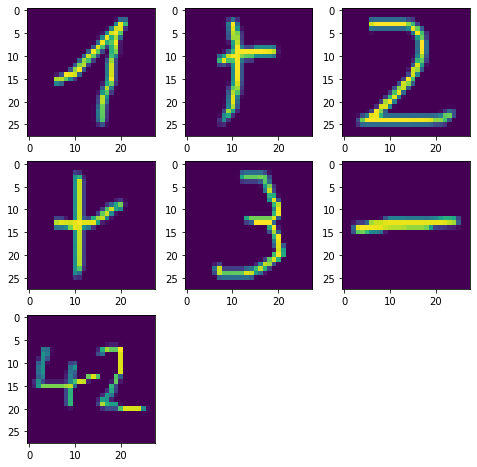

In [12]:
images_white_line = split_by_white_line(input_img)
images_white_line = [rescale_img(img) for img in images_white_line]

plot_image_list(images_white_line)

### Approach 2: Split by Contour

The following splits the input image by detecting a white contour around the symbols and rescales the discovered entities for further processing.

With this approach we cover cases, where symbols are not completely separatable by a straight vertical white line.

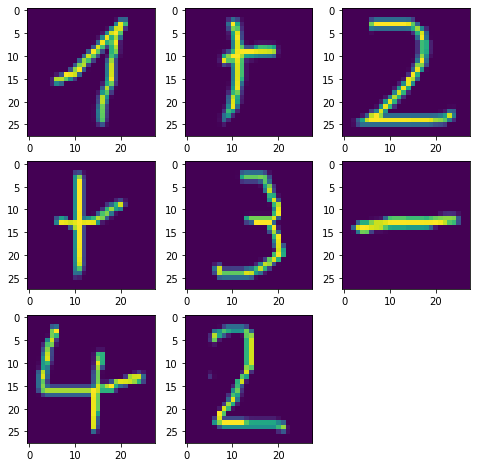

In [13]:
images_contour = split_by_contour(input_img)
images_contour = [rescale_img(img) for img in images_contour]

plot_image_list(images_contour)

## Building Block 3: Recognizing Single Digits And Symbols

**Input:** A list of sub-images, containing one digit/symbol each

**Output:** A list containing the recognized digits and symbols

---

We trained a fresh CNN on the MNIST dataset of handwritten digits (plus the signs '+' and '-').

In the following we load this model for inference (see ***Single_Digit_Recognition.ipynb*** for the code)

In [29]:
import torch.nn as nn

class CNN(nn.Module):                  #Score: 99.2%
    def __init__(self, out_classes):
        super(CNN, self).__init__()

        self.conv1 = nn.Sequential(     #Input 28*28*1     
            nn.Conv2d(in_channels=1, out_channels=32, kernel_size=5, stride=1, padding=0), #Output 24*24*32                              
            nn.ReLU(),                      
            nn.MaxPool2d(kernel_size=2) #Output 12*12*32
        )
        self.conv2 = nn.Sequential(         
            nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3, tride=1, padding=0), #Output 10*10*64
            nn.ReLU(),                      
            nn.MaxPool2d(kernel_size=2), #Output 5*5*64              
        )
        self.dense = nn.Sequential(
            nn.Linear(5*5*64, 128),
            nn.ReLU(),
            nn.Dropout(0.3),
            nn.Linear(128, 64),
            nn.ReLU(),
            nn.Dropout(0.5),
            nn.Linear(64, out_classes)
        )

    def forward(self, x):
        # Put through 2 convolution layers and a 3L deep linear network with dropouts
        x = self.conv1(x)
        x = self.conv2(x)
        x = x.view(x.size(0), -1) #Flatten
        output = self.dense(x)
        return output

    def out(self, x):
      return self.forward(x)

In [15]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [16]:
import torch
model = torch.load('/content/drive/MyDrive/cnn.pth')
model.eval()

CNN2(
  (conv1): Sequential(
    (0): Conv2d(1, 32, kernel_size=(5, 5), stride=(1, 1))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (conv2): Sequential(
    (0): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (dense): Sequential(
    (0): Linear(in_features=1600, out_features=128, bias=True)
    (1): ReLU()
    (2): Dropout(p=0.3, inplace=False)
    (3): Linear(in_features=128, out_features=64, bias=True)
    (4): ReLU()
    (5): Dropout(p=0.5, inplace=False)
    (6): Linear(in_features=64, out_features=12, bias=True)
  )
)

In [17]:
def predict(images: list, model=model) -> list:
  """
  Calls Model to predict each image from the input list. Returns a list of most
  likely prediction for each image.

  Args:
    images: (list) list of images for model to predict
    (optional) model: (torch model) model to use (defaults to variable 'model')

  Returns:
    labels: (list) list of predictions as string
  """

  classes = ["0", "1", "2", "3", "4", "5", "6", "7", "8", "9", "+", "-"]
  labels = []

  for img in images:
    x = np.expand_dims(img,axis=(0,1))
    output = model(torch.Tensor(x))
    _, predicted = torch.max(output.data, 1)
    labels.append(classes[predicted])
  
  return labels

**Output of the Network for Vertical Line Separation:**

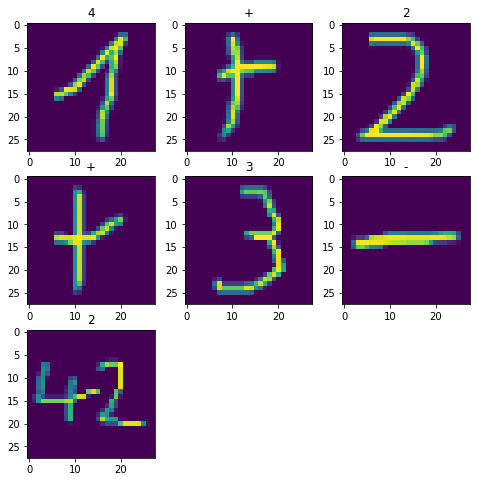

In [18]:
labels_white_line = predict(images_white_line)
plot_image_list(images_white_line, labels_white_line)

**Output of the Network for Separation by Contour:**

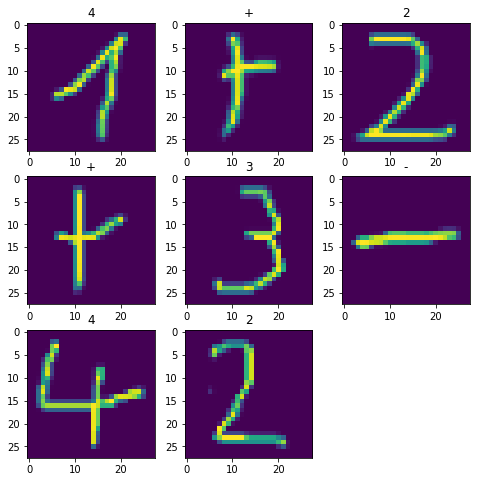

In [19]:
labels_contour = predict(images_contour)
plot_image_list(images_contour, labels_contour)

In [20]:
labels_contour

['4', '+', '2', '+', '3', '-', '4', '2']

## Building Block 4: Parsing And Evaluating The Sequence

**Input:** A list containing the digits and symbols, e.g. `[1, "+", 2, "+", "3"]`

**Output**: The result of the calculation, e.g. `1 + 2 + 3` = `6`

---

In [21]:
eval(''.join(labels_contour))

-33

## Putting it all together

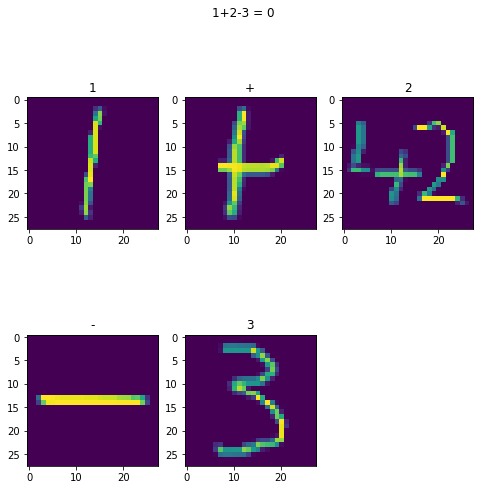

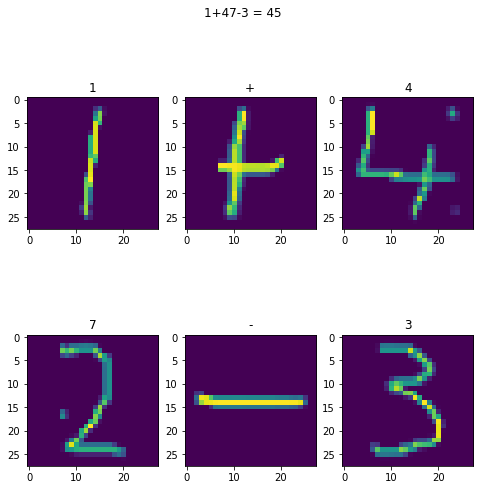

In [23]:
from IPython.core.display import display_html
input = draw_canvas()

#Split by white line and contour
for images in [split_by_white_line(input), split_by_contour(input)]:
  #Rescale for NN
  images = [rescale_img(img) for img in images]

  #Predict and convert classes to string
  labels = predict(images)
    
  #Display and calculate recognized symbols
  formula = ''.join(labels)
  try:
    result = str(eval(formula))
  except:
    result = 'NaN'
  
  plot_image_list(images, labels, figure_title=f"{formula} = {result}")

## TrOCR Model Inference

As you can see we got some acceptable, but not outstanding results from our pipeline approach, especially when splitting by contour.

Much better results can be achieved by finetuning a transformer model for text recognition.

In the following we load a finetuned model from model weights (refer to ***trOCR.ipynb*** to see the code).

In [24]:
!pip install transformers

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.3/6.3 MB 40.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.6/7.6 MB 92.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 190.3/190.3 KB 21.8 MB/s eta 0:00:00


In [25]:
from transformers import ViTFeatureExtractor, VisionEncoderDecoderModel, TrOCRProcessor
import numpy as np

In [26]:
processor = TrOCRProcessor.from_pretrained("microsoft/trocr-base-handwritten")
tokenizer = ViTFeatureExtractor.from_pretrained("google/vit-base-patch16-384")
model = VisionEncoderDecoderModel.from_pretrained('drive/MyDrive/dlproject/model') # load fine-tuned TrOCR model from Google Drive

Could not find image processor class in the image processor config or the model config. Loading based on pattern matching with the model's feature extractor configuration.


/usr/local/lib/python3.8/dist-packages/transformers/models/vit/feature_extraction_vit.py:28: FutureWarning: The class ViTFeatureExtractor is deprecated and will be removed in version 5 of Transformers. Please use ViTImageProcessor instead.
  warnings.warn(


In [27]:
# Image preprocessing
tr_img = 255 - input_img # invert image
tr_img = Image.fromarray(tr_img).convert('RGB')
pixel_values = tokenizer(tr_img, return_tensors="pt").pixel_values

# OCR
generated_ids = model.generate(pixel_values)
generated_text = processor.batch_decode(generated_ids, skip_special_tokens=True)[0]

/usr/local/lib/python3.8/dist-packages/transformers/generation/utils.py:1273: UserWarning: Neither `max_length` nor `max_new_tokens` has been set, `max_length` will default to 64 (`generation_config.max_length`). Controlling `max_length` via the config is deprecated and `max_length` will be removed from the config in v5 of Transformers -- we recommend using `max_new_tokens` to control the maximum length of the generation.
  warnings.warn(


1+2+42


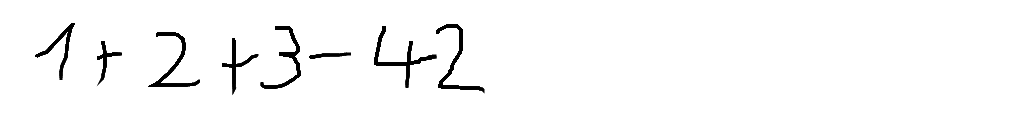

In [28]:
print(generated_text)
tr_img